In [1]:
# visualize the iamge using the dataloader class
from data.dataset import SaltDataset

In [4]:
dataset = SaltDataset(
                csv_file ='../data/train.csv',
                image_dir = '../data/train/images',
                mask_dir = '../data/train/masks',
                depths_csv = '../data/depths.csv',
                use_2_5d = True,
                mode = 'train'
            )

In [7]:
dataset_size = len(dataset)
print("dataset size: ", dataset_size)

dataset size:  4000


In [15]:
import random
import numpy as np

idx = random.randint(0, len(dataset)-1)
sample = dataset[idx]
image, mask = sample
print('image shape: ', image.shape)
print('mask shape: ', mask.shape)

image = np.transpose(image, (1, 2, 0))
print('image shape after transpose: ', image.shape)

mask = np.transpose(mask, (1, 2, 0))
print('mask shape after transpose: ', mask.shape)

image shape:  torch.Size([3, 101, 101])
mask shape:  torch.Size([1, 101, 101])
image shape after transpose:  torch.Size([101, 101, 3])
mask shape after transpose:  torch.Size([101, 101, 1])


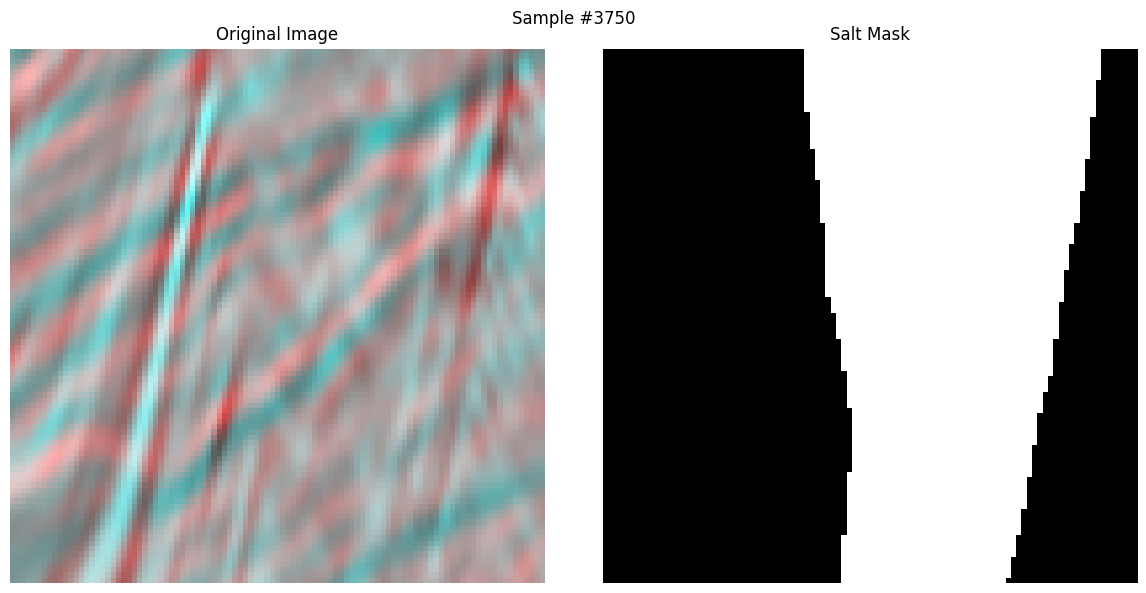

Image shape: torch.Size([101, 101, 3])
Mask shape: torch.Size([101, 101, 1])


In [16]:
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Salt Mask')
plt.axis('off')

plt.suptitle(f'Sample #{idx}')
plt.tight_layout()
plt.show()

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

In [28]:
import torch

# Function to get and preprocess a sample
def get_processed_sample(idx):
    sample = dataset[idx]
    
    # Extract image and mask
    if isinstance(sample, dict):
        image = sample['image']
        mask = sample['mask']
    else:
        # Assuming it's a tuple with (image, mask) format
        image, mask = sample
    
    # Convert to numpy for visualization if they are PyTorch tensors
    if isinstance(image, torch.Tensor):
        image = image.numpy()
        if image.shape[0] == 1 or image.shape[0] == 3:  # CHW format
            image = np.transpose(image, (1, 2, 0))
        if len(image.shape) > 2 and image.shape[-1] == 1:  # Remove singleton dimension
            image = image.squeeze(-1)
            
    if isinstance(mask, torch.Tensor):
        mask = mask.numpy()
        if len(mask.shape) > 2 and mask.shape[0] == 1:  # CHW format with single channel
            mask = mask.squeeze(0)
        if len(mask.shape) > 2 and mask.shape[-1] == 1:  # Remove singleton dimension
            mask = mask.squeeze(-1)
    
    return image, mask


# Function to create overlay visualization
def create_overlay(image, mask, alpha=0.5, mask_color=[1, 0, 0]):
    """
    Create an overlay of the mask on the image.
    
    Args:
        image: Grayscale image
        mask: Binary mask
        alpha: Transparency of the overlay
        mask_color: Color of the mask overlay in RGB
    
    Returns:
        Overlay image
    """
    # Ensure image is in the range [0, 1]
    if image.max() > 1:
        image = image / 255.0
    
    # Create RGB version of grayscale image
    # rgb_image = np.stack([image] * 3, axis=-1)
    print('image shape: ', image.shape)
    # print('rgb image shape: ', rgb_image.shape)
    
    if len(mask.shape) > 2:
        mask = mask.squeeze()

    # Create colored mask
    colored_mask = np.zeros_like(image)
    if len(mask.shape) == 2:  # If mask is 2D
        colored_mask[..., 0] = mask * mask_color[0]
        colored_mask[..., 1] = mask * mask_color[1]
        colored_mask[..., 2] = mask * mask_color[2]
    else:  # If mask is already 3D
        colored_mask = mask
        
    # Create overlay
    overlay = image * (1 - alpha) + colored_mask * alpha
    
    # Clip values to be between 0 and 1
    overlay = np.clip(overlay, 0, 1)
    
    return overlay
    


image shape:  (101, 101, 3)
image shape:  (101, 101, 3)
image shape:  (101, 101, 3)
image shape:  (101, 101, 3)


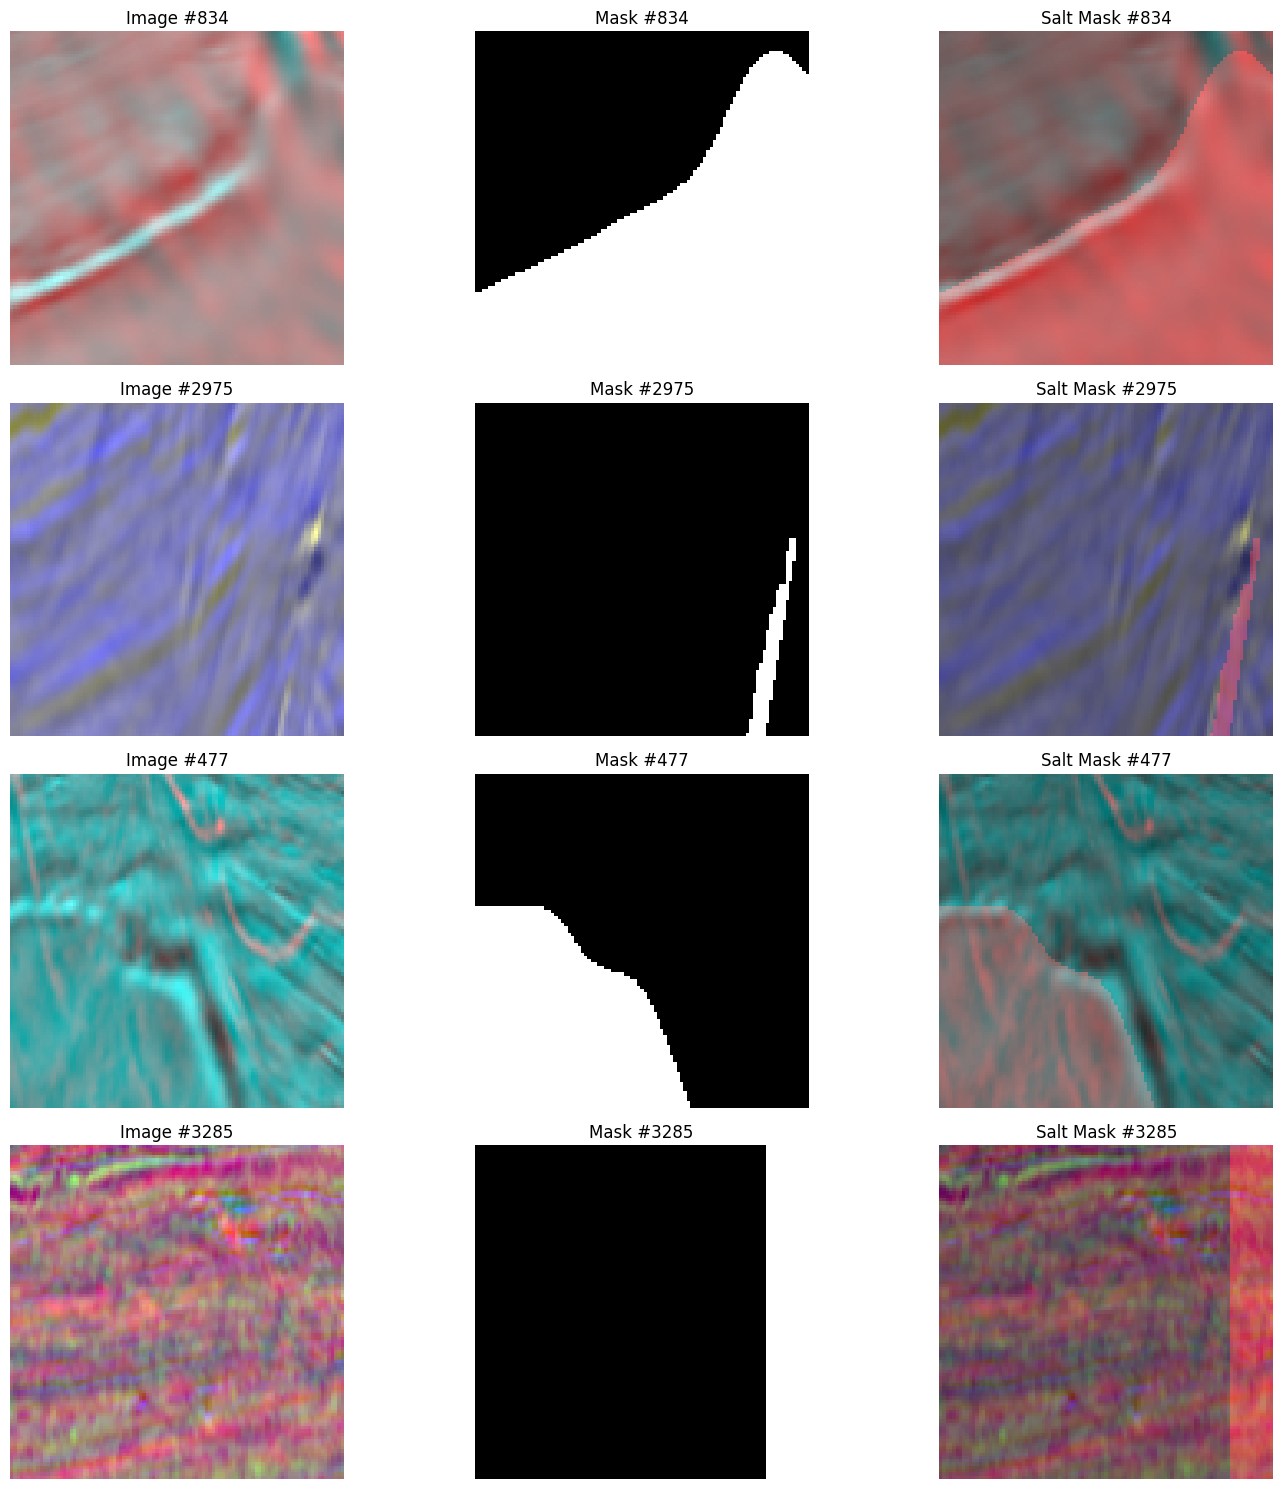

In [29]:
# Display a grid of samples
num_samples = 4
plt.figure(figsize=(15, 15))

for i in range(num_samples):
    idx = random.randint(0, len(dataset)-1)
    image, mask = get_processed_sample(idx)
    
    # Original image
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Image #{idx}')
    plt.axis('off')
    
    # Mask
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Mask #{idx}')
    plt.axis('off')
    
    # Overlay (we'll create this in the next section)
    plt.subplot(num_samples, 3, i*3 + 3)
    overlay = create_overlay(image, mask, alpha=0.3)
    plt.imshow(overlay, cmap='gray')
    plt.title(f'Salt Mask #{idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()

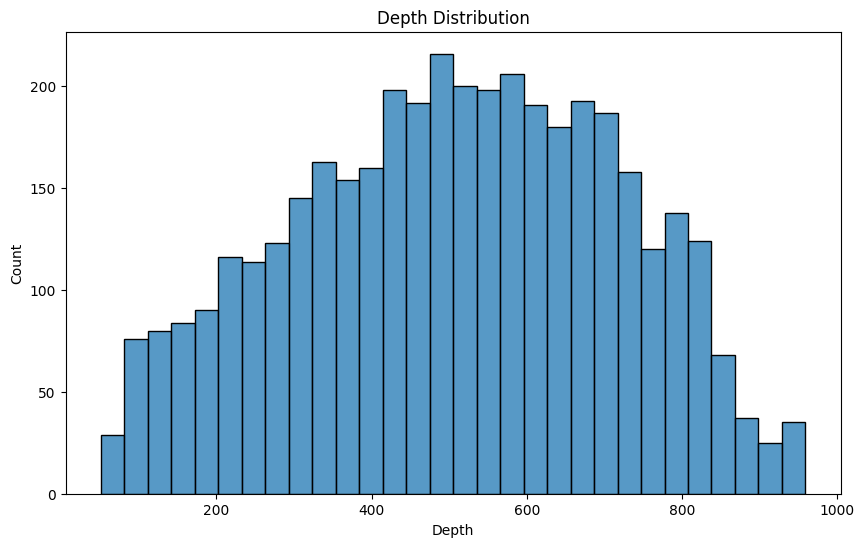

In [37]:
import pandas as pd
import seaborn as sns

# visualize depth distribution
depths = dataset.df

plt.figure(figsize=(10, 6))
if isinstance(depths, pd.DataFrame):
    sns.histplot(depths['z'], bins=30)
else:
    # If depths is a list or array
    sns.histplot(depths, bins=30)
plt.title('Depth Distribution')
plt.xlabel('Depth')
plt.ylabel('Count')
plt.show()

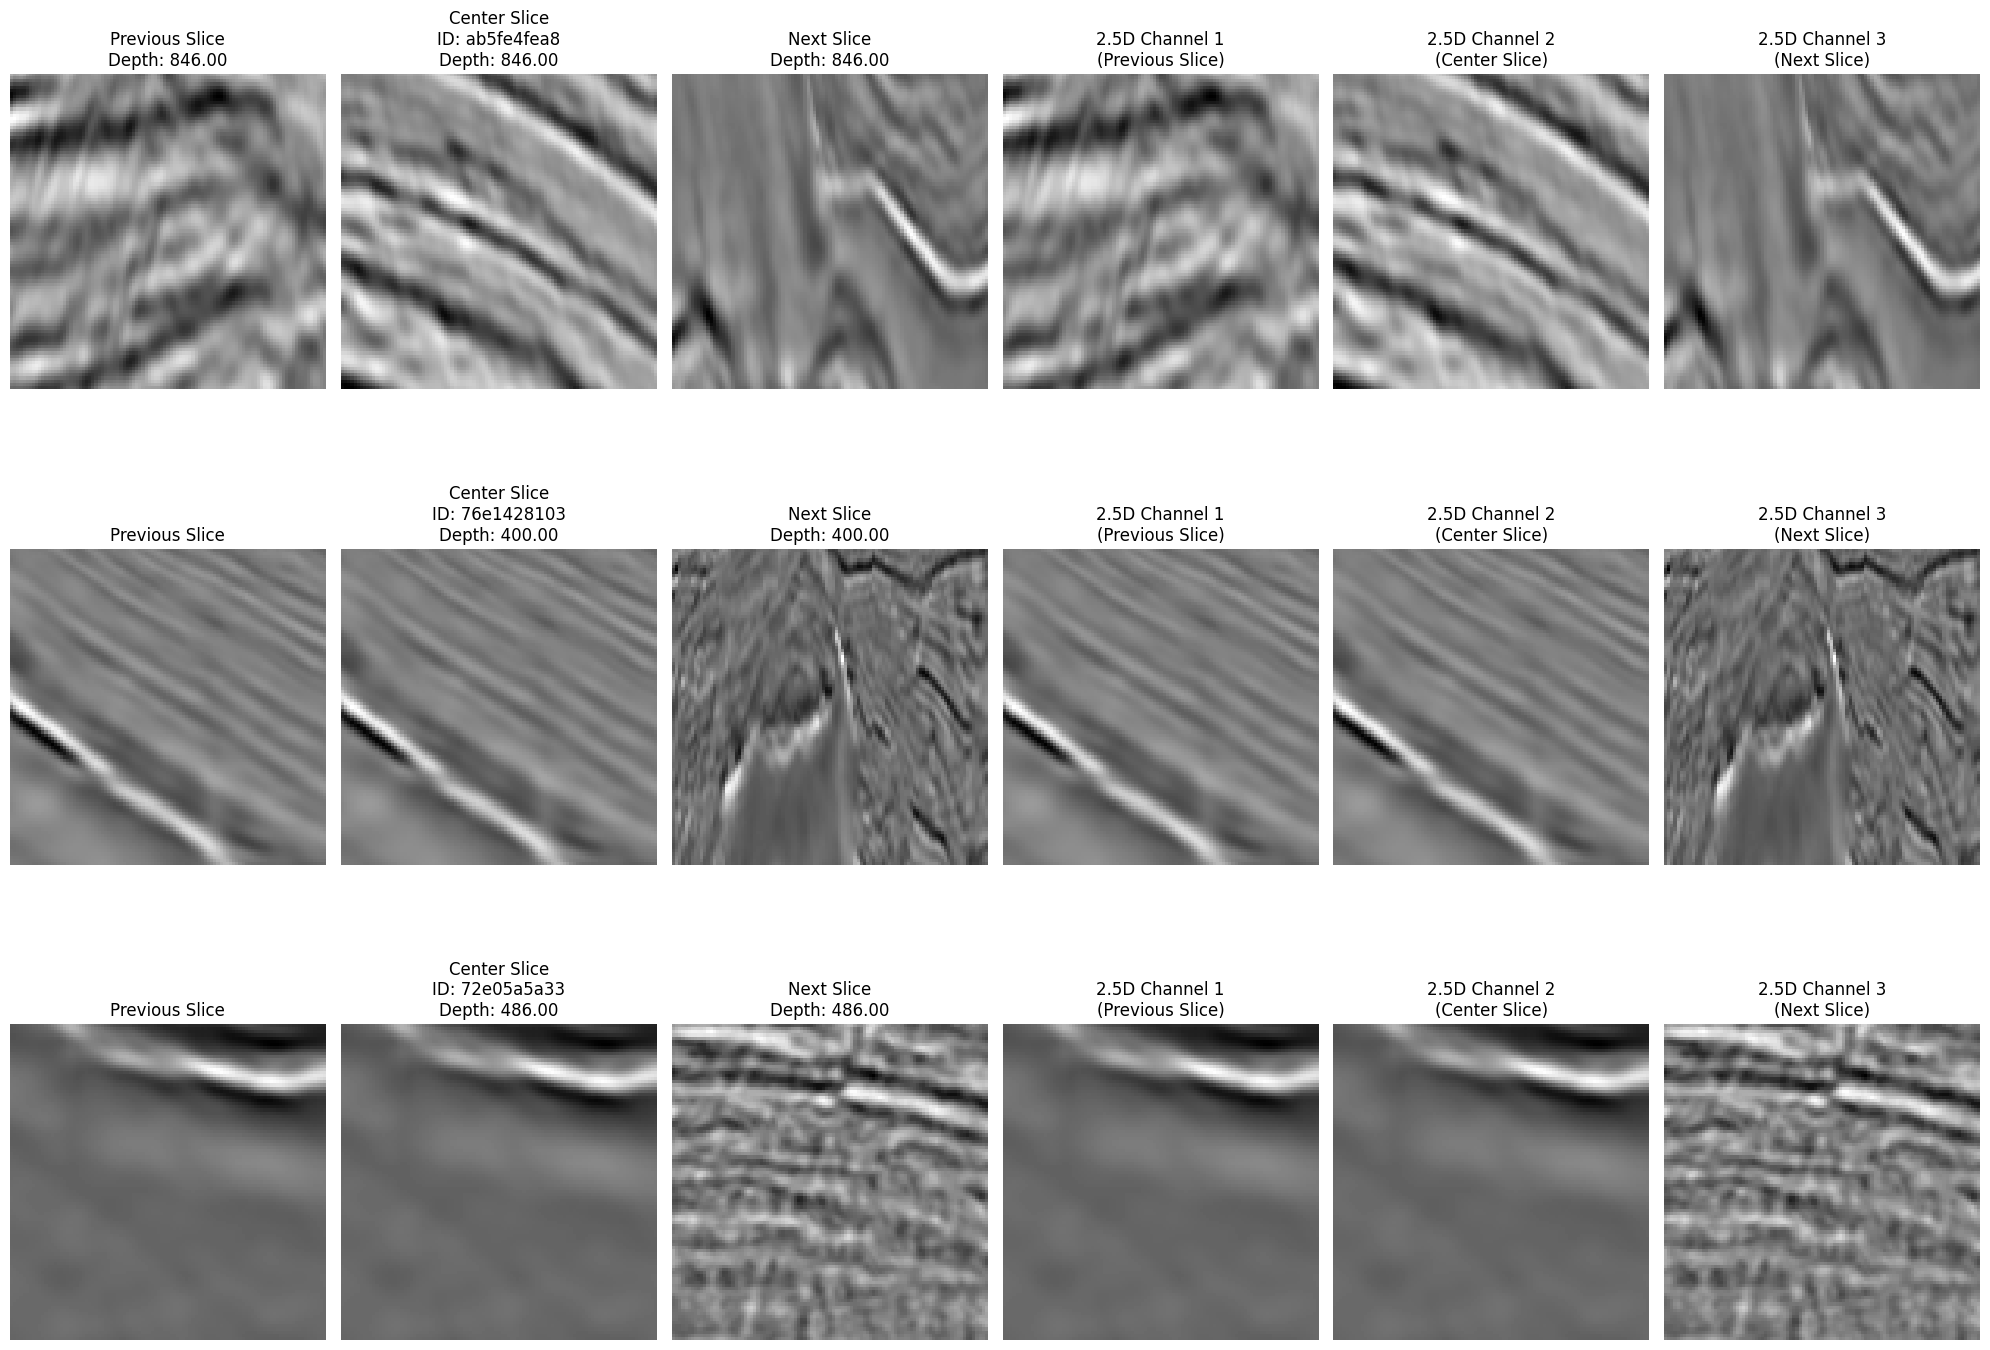

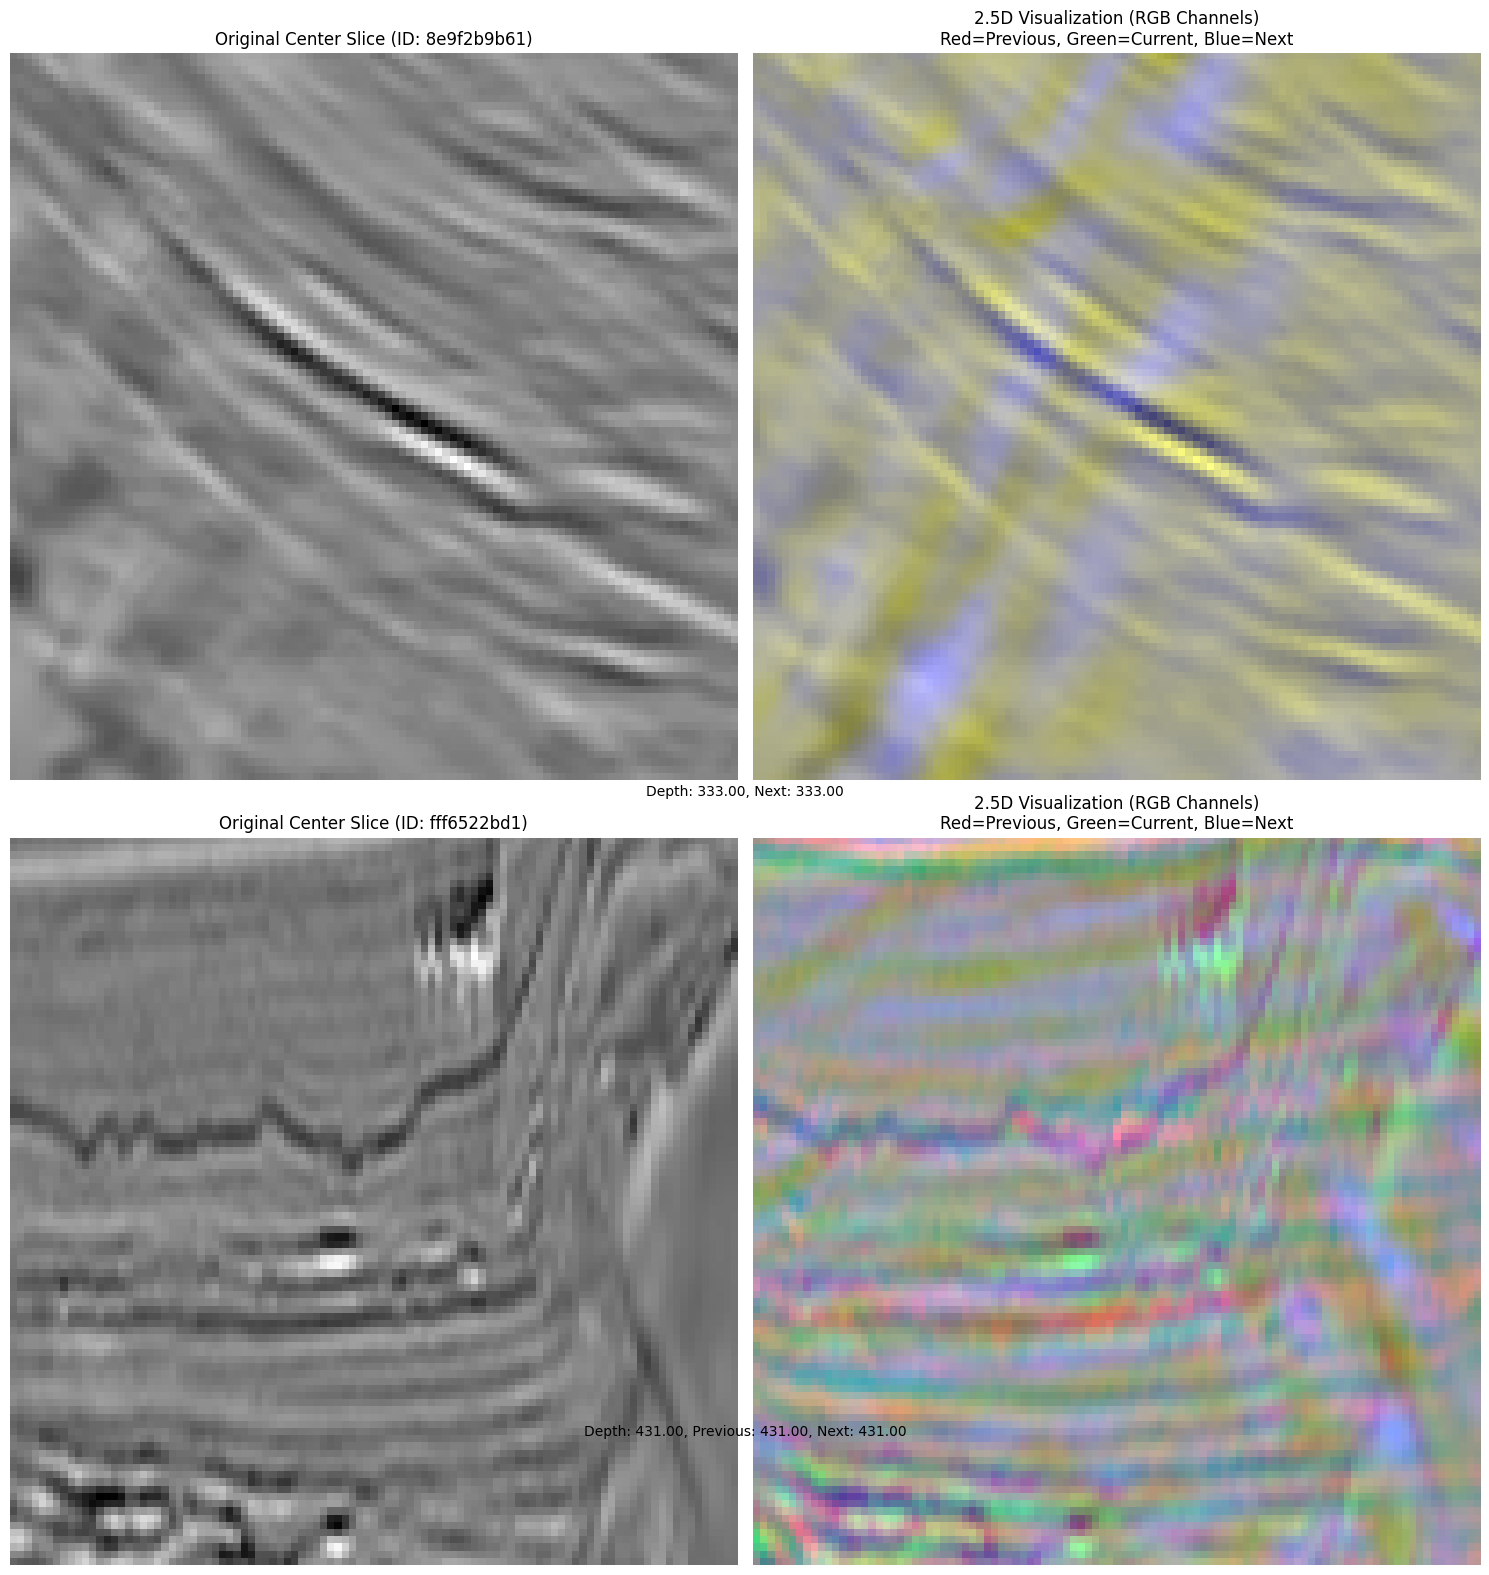

In [38]:
# visualize the 2.5D stacking

# Function to get individual slices from a 2.5D image
def get_individual_slices(idx):
    """
    Extract and return individual slices from a 2.5D image
    """
    image_id = dataset.image_ids[idx]
    
    # Get neighbor indices
    prev_idx, next_idx = dataset._get_neighbor_slices(idx)
    
    # Load center slice
    center_slice = dataset._load_image(image_id)
    if len(center_slice.shape) > 2:  # Has channels
        center_slice = np.mean(center_slice, axis=2, keepdims=False)
    
    # Load neighbor slices or duplicate center slice if neighbors don't exist
    prev_slice = None
    next_slice = None
    
    if prev_idx is not None:
        prev_image_id = dataset.image_ids[prev_idx]
        prev_slice = dataset._load_image(prev_image_id)
        if len(prev_slice.shape) > 2:
            prev_slice = np.mean(prev_slice, axis=2, keepdims=False)
    else:
        prev_slice = center_slice.copy()
        
    if next_idx is not None:
        next_image_id = dataset.image_ids[next_idx]
        next_slice = dataset._load_image(next_image_id)
        if len(next_slice.shape) > 2:
            next_slice = np.mean(next_slice, axis=2, keepdims=False)
    else:
        next_slice = center_slice.copy()
    
    # Load mask for center slice
    mask = dataset._load_mask(image_id)
    
    # Return info about the slices and their indices
    slice_info = {
        'prev_slice': prev_slice,
        'center_slice': center_slice,
        'next_slice': next_slice,
        'mask': mask,
        'prev_idx': prev_idx,
        'center_idx': idx,
        'next_idx': next_idx,
        'prev_id': dataset.image_ids[prev_idx] if prev_idx is not None else None,
        'center_id': image_id,
        'next_id': dataset.image_ids[next_idx] if next_idx is not None else None,
    }
    
    if dataset.depth_values is not None:
        slice_info['prev_depth'] = dataset.depth_values[prev_idx] if prev_idx is not None else None
        slice_info['center_depth'] = dataset.depth_values[idx]
        slice_info['next_depth'] = dataset.depth_values[next_idx] if next_idx is not None else None
    
    return slice_info

# Visualize 2.5D slices for random samples
num_samples = 3
plt.figure(figsize=(20, 5 * num_samples))

for i in range(num_samples):
    idx = random.randint(0, len(dataset)-1)
    slice_info = get_individual_slices(idx)
    
    # Get the 2.5D combined image (as returned by dataset)
    combined_image, mask = dataset[idx]
    combined_image = combined_image.numpy()
    
    # Create a 2x3 subplot
    plt.subplot(num_samples, 6, i*6 + 1)
    plt.imshow(slice_info['prev_slice'], cmap='gray')
    prev_label = f"Previous Slice"
    if slice_info['prev_depth'] is not None:
        prev_label += f"\nDepth: {slice_info['prev_depth']:.2f}"
    plt.title(prev_label)
    plt.axis('off')
    
    plt.subplot(num_samples, 6, i*6 + 2)
    plt.imshow(slice_info['center_slice'], cmap='gray')
    center_label = f"Center Slice\nID: {slice_info['center_id']}"
    if slice_info['center_depth'] is not None:
        center_label += f"\nDepth: {slice_info['center_depth']:.2f}"
    plt.title(center_label)
    plt.axis('off')
    
    plt.subplot(num_samples, 6, i*6 + 3)
    plt.imshow(slice_info['next_slice'], cmap='gray')
    next_label = f"Next Slice"
    if slice_info['next_depth'] is not None:
        next_label += f"\nDepth: {slice_info['next_depth']:.2f}"
    plt.title(next_label)
    plt.axis('off')
    
    # Visualize the 3 channels of the combined image (RGB representation)
    plt.subplot(num_samples, 6, i*6 + 4)
    plt.imshow(combined_image[0], cmap='gray')
    plt.title("2.5D Channel 1\n(Previous Slice)")
    plt.axis('off')
    
    plt.subplot(num_samples, 6, i*6 + 5)
    plt.imshow(combined_image[1], cmap='gray')
    plt.title("2.5D Channel 2\n(Center Slice)")
    plt.axis('off')
    
    plt.subplot(num_samples, 6, i*6 + 6)
    plt.imshow(combined_image[2], cmap='gray')
    plt.title("2.5D Channel 3\n(Next Slice)")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Create a colorful visualization of the 2.5D representation
num_samples = 2
plt.figure(figsize=(15, 8 * num_samples))

for i in range(num_samples):
    idx = random.randint(0, len(dataset)-1)
    slice_info = get_individual_slices(idx)
    
    # Get the 2.5D combined image
    combined_image, mask = dataset[idx]
    combined_image = combined_image.numpy()
    
    # Create a false color representation (RGB channels)
    rgb_image = np.zeros((combined_image.shape[1], combined_image.shape[2], 3))
    rgb_image[:,:,0] = combined_image[0]  # Previous slice -> Red
    rgb_image[:,:,1] = combined_image[1]  # Current slice -> Green
    rgb_image[:,:,2] = combined_image[2]  # Next slice -> Blue
    
    # Normalize for better visualization
    rgb_image = np.clip(rgb_image, 0, 1)
    
    # Create a 2-row visualization
    plt.subplot(num_samples, 2, i*2 + 1)
    plt.imshow(slice_info['center_slice'], cmap='gray')
    plt.title(f"Original Center Slice (ID: {slice_info['center_id']})")
    plt.axis('off')
    
    plt.subplot(num_samples, 2, i*2 + 2)
    plt.imshow(rgb_image)
    plt.title("2.5D Visualization (RGB Channels)\nRed=Previous, Green=Current, Blue=Next")
    plt.axis('off')
    
    # Add depth info if available
    if slice_info['center_depth'] is not None:
        depth_info = f"Depth: {slice_info['center_depth']:.2f}"
        if slice_info['prev_depth'] is not None:
            depth_info += f", Previous: {slice_info['prev_depth']:.2f}"
        if slice_info['next_depth'] is not None:
            depth_info += f", Next: {slice_info['next_depth']:.2f}"
        plt.figtext(0.5, 0.5 - i*0.4, depth_info, ha='center')

plt.tight_layout()
plt.show()